In [ ]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 53 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619421 sha256=0e05a69847eaf1376e634b1a7614133f2d7f7b9eff9506f1cd5c3fe7cad4b55a
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
# surprise library
from surprise import Dataset, Reader

from surprise import SVD, SVDpp, NMF
from surprise.model_selection import \
    train_test_split, GridSearchCV, cross_validate, PredefinedKFold

from surprise import accuracy
from surprise.model_selection import KFold
from surprise.prediction_algorithms.knns import KNNWithMeans

from surprise import SlopeOne, CoClustering

from surprise import dump

import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Spiderum/Data

/content/drive/MyDrive/Spiderum/Data


In [ ]:
data = pd.read_csv('./Data for CF/cleaned_data.csv')
data.head()

,user_id,redirect_url,rating,created_at
0,5,https://spiderum.com/bai-dang/CHINH-THUC-SPIDE...,1,2020-09-30 03:09:34
1,5,https://spiderum.com/bai-dang/Cung-Spiderum-hu...,1,2020-10-22 09:48:33
2,5,https://spiderum.com/bai-dang/Dau-tu-vao-nhan-...,1,2020-02-13 07:48:36
3,5,https://spiderum.com/bai-dang/NGUYEN-PHUONG-DU...,1,2021-03-08 06:29:42
4,5,https://spiderum.com/bai-dang/Nguoi-tre-noi-gi...,1,2020-08-19 06:23:04


In [ ]:
interact_df = pd.read_csv('./Data for CF/interact_CF.csv')
interact_df.head()

,user_id,redirect_url,created_at
0,5,https://spiderum.com/bai-dang/Toi-chi-muon-con...,2019-08-09 07:00:21
1,5,https://spiderum.com/bai-dang/Dau-tu-vao-nhan-...,2020-02-13 07:48:36
2,5,https://spiderum.com/bai-dang/Talkshow-ra-mat-...,2020-07-22 04:50:12
3,5,https://spiderum.com/bai-dang/Nguoi-tre-noi-gi...,2020-08-19 06:23:04
4,5,https://spiderum.com/bai-dang/CHINH-THUC-SPIDE...,2020-09-30 03:09:34


In [ ]:
posts = pd.read_csv('./posts.csv')
posts['redirect_url'] = 'https://spiderum.com/bai-dang/' + posts['slug']
posts = posts[['redirect_url', 'point']]
posts.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17,19,26,28,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,redirect_url,point
0,https://spiderum.com/bai-dang/Chao-mung-toi-sp...,25
1,https://spiderum.com/bai-dang/Chuyen-tinh-dam-...,17
2,https://spiderum.com/bai-dang/Tinh-nguoi-3,129
3,https://spiderum.com/bai-dang/Danh-cho-nhung-b...,24
4,https://spiderum.com/bai-dang/Nghe-thuat-dam-p...,23


In [ ]:
# Add points column to interact_df
interact_df = interact_df.merge(posts[['redirect_url', 'point']], how='inner', left_on='redirect_url', right_on='redirect_url')

In [ ]:
data['rating'].value_counts()

 1    609134
 2    109313
-1     19519
 3      6768
Name: rating, dtype: int64

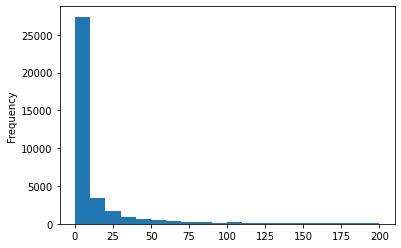

In [ ]:
data.groupby('user_id').count().reset_index()['rating'].plot.hist(range=(0, 200), bins=20)

# Build model SVD (Matrix Factorization)

In [ ]:
import collections
import random

class CF(object):
    def __init__(self, data, interact_df):
        self.data = data
        self.model = None
        self.trainset = None
        self.testset = None
        self.final_testset = None
        self.trainset_prepared = None
        self.testset_prepared = None
        self.final_testset_prepared = None
        self.testset_dict_for_eval = None
        self.interact_df = interact_df
    
    def create_final_testset(self):
        # Shorten testset
        self.testset = self.testset[self.testset['user_id'].isin(self.trainset['user_id'])]
        self.testset = self.testset[self.testset['redirect_url'].isin(self.trainset['redirect_url'])]
        self.testset = self.testset[self.testset['rating'] >= 1]

        # Shorten interact_df
        self.interact_df = self.interact_df[self.interact_df['user_id'].isin(self.testset['user_id'])]
        self.interact_df = self.interact_df[self.interact_df['redirect_url'].isin(self.trainset['redirect_url'])]

        # Create testset_dict_for_eval
        self.testset_dict_for_eval = self.testset[['user_id', 'redirect_url']] \
                                    .groupby('user_id').agg({'redirect_url': lambda x: tuple(x)}).to_dict()['redirect_url']

        # Create final testset
        self.interact_df['code'] = self.interact_df['user_id'].astype(str) + self.interact_df['redirect_url']
        self.trainset['code'] = self.trainset['user_id'].astype(str) + self.trainset['redirect_url']
        self.final_testset = self.interact_df[~self.interact_df['code'].isin(self.trainset['code'])][['user_id', 'redirect_url']]
        self.final_testset['rating'] = 0
        self.final_testset_prepared = Dataset.load_from_df(self.final_testset, Reader()).build_full_trainset().build_testset()

    def train_model(self, lr_all, n_epochs, n_factors, reg_all, biased=False):
        self.model = SVD(lr_all=lr_all, n_epochs=n_epochs, n_factors=n_factors, reg_all=reg_all)
        self.model.fit(self.trainset_prepared)
    
    def calculate_acc(self):
        # Training acc
        predictions = self.model.test(self.trainset.build_testset())
        error = accuracy.rmse(predictions, verbose = False)
        print('Training acc: ')
        print(error)
        
        # Testing acc
        predictions_test = self.model.test(self.testset)
        error = accuracy.rmse(predictions_test, verbose = False)
        print('Testing acc: ')
        print(error)
    
    def save_model(self, path):
        dump.dump('./Data for CF/svd_model',algo=self.model)
    
    def load_model(self, path):
        self.model = dump.load('./Data for CF/svd_model')[1]
    
    def calculate_map(self, k, method='normal'):
        if method == 'popularity':
            final_testset_popularity = self.interact_df[~self.interact_df['code'].isin(self.trainset['code'])]
            top_n = collections.defaultdict(list)
            for uid, iid, view_count in zip(final_testset_popularity['user_id'], final_testset_popularity['redirect_url'], final_testset_popularity['point']):
                top_n[uid].append((iid, view_count))
        else:
            predictions = self.model.test(self.final_testset_prepared)
            top_n = collections.defaultdict(list)
            for uid, iid, true_r, est, _ in predictions:
                top_n[uid].append((iid, est))

        # Then sort the predictions for each user and retrieve the k highest ones.
        for uid, ratings in top_n.items():
            if method == 'normal':
                #ratings = [x for x in ratings if x[1] > 1.01] # Filter rating > 1.05
                ratings.sort(key=lambda x: x[1], reverse=True)
            elif method == 'baseline':
                random.shuffle(ratings)
            top_n[uid] = ratings[:k][:len(self.testset_dict_for_eval[uid])]
        
        # Calculate map
        ap_mat = np.full((self.trainset_prepared.n_users, k), np.nan)
        for uid, ratings in top_n.items():
            row_idx = self.trainset_prepared.to_inner_uid(uid)
            n = 0
            for i, (url, _) in enumerate(ratings):
                if url in self.testset_dict_for_eval[uid]:
                    n += 1
                ap_mat[row_idx][i] = n/(i + 1)

        map = np.nanmean(ap_mat, axis=0)
        return map

    def evaluate_model(self, lr_all, n_epochs, n_factors, reg_all, k, method='baseline'):
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        map = 0
        for idx_train, idx_test in kfold.split(self.data):
            self.trainset = self.data.iloc[idx_train, :3]
            self.testset = self.data.iloc[idx_test, :3]
            self.trainset_prepared = Dataset.load_from_df(self.trainset, Reader()).build_full_trainset()
            self.testset_prepared = Dataset.load_from_df(self.testset, Reader()).build_full_trainset().build_testset()
            
            self.create_final_testset()
            self.train_model(lr_all, n_epochs, n_factors, reg_all, biased=False)
            map_each_fold = self.calculate_map(k, method=method)
            print(map_each_fold.mean())
            map += map_each_fold/10

        return map

    def train_model_for_recommendation(self, lr_all, n_epochs, n_factors, reg_all):
        self.trainset_prepared = Dataset.load_from_df(self.data.iloc[:, :3], Reader()).build_full_trainset()
        self.model = SVD(lr_all=lr_all, n_epochs=n_epochs, n_factors=n_factors, reg_all=reg_all, biased=False)
        self.model.fit(self.trainset_prepared)

    def top_n_recommend(self, n):
        list_user_ids = list(set(self.data['user_id']))
        list_urls = list(set(self.data['redirect_url']))
        top_n = collections.defaultdict(list)

        for user_id in random.choices(population=list_user_ids, k=1000): #sample 1000 users
            print('{}: {}'.format(user_id, len(self.data[self.data['user_id'] == user_id])))
            not_interact_urls = list(set(list_urls) - set(self.interact_df[self.interact_df['user_id'] == user_id]['redirect_url']))
            not_interact_df = pd.DataFrame({'user_id': [user_id for _ in range(len(not_interact_urls))],
                                            'redirect_url': not_interact_urls,
                                            'rating': [0 for _ in range(len(not_interact_urls))]})
            not_interact_df_prepared = Dataset.load_from_df(not_interact_df, Reader()).build_full_trainset().build_testset()
            predictions = self.model.test(not_interact_df_prepared)
            
            for uid, iid, true_r, est, _ in predictions:
                top_n[uid].append((iid, est))
            top_n[uid] = sorted(top_n[uid], key=lambda x: x[1], reverse=True)[:n]

        return top_n


In [ ]:
a = CF(data, interact_df)

In [ ]:
map_random = a.evaluate_model(lr_all=0.005, n_epochs=50, n_factors=100, reg_all=0.01, k=20, method='normal')

0.08076243277767398
0.08292695303341542
0.08525232728262304
0.08024841726642781
0.07958596803182824
0.07970165552257195
0.08239909616732925
0.07977404109702987
0.07997891803348638
0.0817711791628929


Text(0, 0.5, 'MAP')

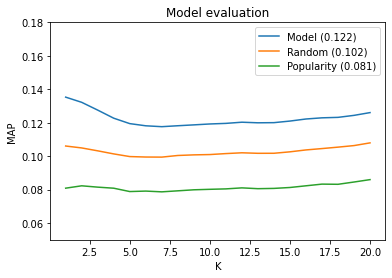

In [ ]:

sns.lineplot(x = range(1, len(map_normal) + 1), y = map_normal, label='Model (0.122)', )
sns.lineplot(x = range(1, len(map_baseline) + 1), y = map_baseline, label='Random (0.102)')
sns.lineplot(x = range(1, len(map_popularity) + 1), y = map_popularity, label='Popularity (0.081)')
plt.ylim(0.05, 0.18)
plt.title('Model evaluation')
plt.xlabel('K')
plt.ylabel('MAP')

In [ ]:
map_normal.mean() 

0.12243997577435199

In [ ]:
a.train_model_for_recommendation(lr_all=0.005, n_epochs=50, n_factors=150, reg_all=0.01)

In [ ]:
top_n_150 = a.top_n_recommend(n=10)

In [ ]:
top_n_150[57952]

[('https://spiderum.com/bai-dang/Viet-tieng-Viet-voi-he-chu-Tien-Tengwar-c24',
  1.5248085498831163),
 ('https://spiderum.com/bai-dang/Di-Kem-Sieu-Tri-Tue-La-Sieu-San-Si-jn6',
  1.5200508726260036),
 ('https://spiderum.com/bai-dang/Con-gai-thich-gi-va-Bai-hoc-meo-con-4wg',
  1.447602505391316),
 ('https://spiderum.com/bai-dang/Thu-Nhap-Tren-10000-USDthang-Thi-Song-Nhu-The-Nao-lkw',
  1.3728957772635006),
 ('https://spiderum.com/bai-dang/Tuoi-tho-va-qua-trinh-hinh-thanh-tinh-cach-con-nguoi-9e8',
  1.3708870099983783),
 ('https://spiderum.com/bai-dang/Toi-la-mot-co-gai-xau-xi-qxr',
  1.363208010659958),
 ('https://spiderum.com/bai-dang/Co-kien-thuc-nao-la-vo-dung-hay-la-tu-duy-lac-hau-ve-giao-duc-5br',
  1.362519674972932),
 ('https://spiderum.com/bai-dang/Ban-muon-co-con-ca-hay-ban-muon-biet-cau-ca-rvh',
  1.3609694800293333),
 ('https://spiderum.com/bai-dang/Ban-ve-ta-dam-va-tantric-sexorSharing-Experienceor-Chuyen-thien-3-laq',
  1.3600006384458019),
 ('https://spiderum.com/bai-dang/E

In [ ]:
def stat_coverage(top_n):
    list_items = [x[0] for x in [item for sublist in list(top_n.values()) for item in sublist] if x[1] > 1.01]
    num_items = len(list_items)
    num_unique_items = len(set(list_items))
    max_num_recommend = collections.Counter(list_items).most_common()[0][1]
    return [num_items, num_unique_items, max_num_recommend]

df = pd.DataFrame(data = {'10 factors': stat_coverage(top_n_10),
                          '25 factors': stat_coverage(top_n_25),
                          '50 factors': stat_coverage(top_n_50),
                          '100 factors': stat_coverage(top_n_100),
                          '150 factors': stat_coverage(top_n_150)},
                  index = ['Số lượt items được recommend', 'Số unique items được recommend', 'Số lần recommend cao nhất của 1 item'])

df

,10 factors,25 factors,50 factors,100 factors,150 factors
Số lượt items được recommend,3546,4102,4141,4050,4233
Số unique items được recommend,347,696,912,1207,1401
Số lần recommend cao nhất của 1 item,184,150,105,36,45


In [ ]:
b = [item for sublist in list(top_n.values()) for item in sublist]
c = [x[0] for x in b if x[1] > 1.01]
import collections
collections.Counter(c).most_common()

[('https://spiderum.com/bai-dang/Danh-gia-ve-chuyen-danh-gia-rbg', 19),
 ('https://spiderum.com/bai-dang/Con-cho-muc-ie9', 14),
 ('https://spiderum.com/bai-dang/Thu-Nhap-Tren-10000-USDthang-Thi-Song-Nhu-The-Nao-lkw',
  13),
 ('https://spiderum.com/bai-dang/THE-OFFICE-US-DA-GIAI-QUYET-VAN-DE-REVIEW-CUA-TUI-NHU-THE-NAO-da5',
  11),
 ('https://spiderum.com/bai-dang/FEMINISM-VA-BINH-DANG-GIOI-qb0', 10),
 ('https://spiderum.com/bai-dang/Tap-uong-va-tim-hieu-ve-ruou-Tay-hay-cocktail-deu-re-khong-y-ma-z27',
  9),
 ('https://spiderum.com/bai-dang/Mau-son-cho-can-cua-Pham-Hien-9xx', 8),
 ('https://spiderum.com/bai-dang/COVID-19-Khi-ca-the-gioi-cung-mo-mam-Ki-1-nqh',
  8),
 ('https://spiderum.com/bai-dang/Danh-cho-nhung-nguoi-muon-tro-nen-sang-tao-lxk',
  7),
 ('https://spiderum.com/bai-dang/VI-SAO-CHUAN-MEN-THI-KHONG-XEM-PORN-VA-QUAY-TAY-q2g',
  7),
 ('https://spiderum.com/bai-dang/Se-ra-sau-neu-cha-me-song-cho-ban-than-nhieu-hon-m3g',
  7),
 ('https://spiderum.com/bai-dang/Toi-khong-thich-minh

In [ ]:
# Tổng số bài được recommend
# Số lần được recommend
# Phương sai của số lần được recommend của mỗi bài